## Airline Tweets data analysis using Data-Prep

In [1]:
# Import thư viện và bỏ qua cảnh báo FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Nhập các thư viện cần thiết cho phân tích dữ liệu và trực quan hóa
from dataprep.eda import create_report

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
from PIL import Image
from gensim.utils import tokenize
import pandas as pd
from textblob import TextBlob
import re
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import string  
import nltk

Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [2]:
# Đọc file CSV chứa dữ liệu huấn luyện
df = pd.read_csv('../data/train_data.csv')
df = df.drop(df.columns[0],axis=1)
df.head()

,username,text,airline_name,tweet_location,airline_sentiment
0,WhaleAlamu,pay my refund. wakanow claimed they are expect...,British_Airways,NaN,Negative
1,roxydigital,@JetBlue @JayVig YES! Great real-time example....,Delta,"Charlotte, NC",Positive
2,jshieber,@USAirways hell is terrible gate agents. And a...,US Airways,New York,Negative
3,JesseSheriff,"@AmericanAir is the new @SpiritAirlines, and b...",American,West Palm Beach,Negative
4,Cmdr_Pants,"i was, the just called, she was very helpful.",SingaporeAir,"Brisbane, Australia",Neutral


In [3]:
# Đọc danh sách stopwords bổ sung từ file stopwords_lda.csv
stopwords_lda = pd.read_csv('../Train_LDA/stopwords_lda.csv')  # File này chứa các từ không cần thiết liên quan đến ngành hàng không

# Hàm tiền xử lý văn bản
def preprocess(text):
    # Lấy danh sách stopwords mặc định từ WordCloud
    stopwords = set(STOPWORDS)  
    
    # Bổ sung các từ không cần thiết từ file stopwords_lda
    stopwords.update([str(i).lower() for i in stopwords_lda.name])  
    
    # Regex để tìm các phần trong văn bản
    mentions_filter = re.compile(r'(?<=\@)(\w+)')  # Tìm @mention
    hashtags_filter = re.compile(r'(?<=\#)(\w+)')  # Tìm hashtag
    flight_numbers = re.compile(r'(flt\d*)')  # Tìm mã chuyến bay (flt123, flt456, ...)
    
    # Tìm các từ tương ứng với regex
    all_mentions = mentions_filter.findall(text.lower())  # Danh sách mentions
    all_hashtag = hashtags_filter.findall(text.lower())  # Danh sách hashtags
    all_flights = flight_numbers.findall(text.lower())  # Danh sách mã chuyến bay
    
    word_lemmatize = WordNetLemmatizer()  # Khởi tạo bộ lemmatizer để chuẩn hóa từ

    # Hàm xử lý từ: lemmatize mỗi từ
    def stem_tokens(tokens, lemmatize):
        lemmatized = []  # Danh sách lưu từ đã xử lý
        for item in tokens:
            lemmatized.append(word_lemmatize.lemmatize(item, 'v'))  # Lemmatize với dạng động từ
        return lemmatized
    
    # Hàm xóa emoji khỏi văn bản
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')  # Bỏ emoji bằng cách chỉ giữ ký tự ASCII
    
    text = deEmojify(text)  # Xóa emoji khỏi văn bản gốc
    soup = BeautifulSoup(text)  # Loại bỏ HTML tags bằng BeautifulSoup
    text = soup.get_text()  # Chỉ giữ nội dung văn bản

    # Loại bỏ dấu câu
    punc_text = [x.lower() for x in text if x not in string.punctuation]  # Loại ký tự không phải chữ cái/số
    text = "".join(punc_text)  # Kết hợp lại thành chuỗi

    # Token hóa văn bản
    word_tokens = nltk.word_tokenize(text)  # Tách thành các từ

    # Chỉ giữ từ có độ dài từ 4 đến 15 ký tự
    filtered_tokens = [x for x in word_tokens if len(x) > 4 and len(x) < 15]

    # Lemmatize và lọc từ không mong muốn
    tokens = stem_tokens(filtered_tokens, word_lemmatize)  # Lemmatize từ
    all_tokens = [i for i in tokens if (i not in stopwords) and (i not in all_mentions)
                  and (i not in all_hashtag) and (i not in all_flights) and (not i.isdigit())]
    return all_tokens  # Trả về danh sách từ đã xử lý

In [4]:
# Áp dụng tiền xử lý văn bản lên cột 'text'
df['text_tokenized']=df['text'].astype("string").map(preprocess)

<ipython-input-3-544a12fd64c9>:36: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text)  # Loại bỏ HTML tags bằng BeautifulSoup


In [5]:
# Tính toán độ dài và số lượng từ trong mỗi tweet
df['tweets_len'] = df['text'].astype(str).apply(len)  # Độ dài mỗi tweet
df['tweets_word_count'] = df['text'].apply(lambda x: len(str(x).split()))  # Số lượng từ
df.head()  # Kiểm tra dữ liệu sau khi thêm cột mới

,username,text,airline_name,tweet_location,airline_sentiment,text_tokenized,tweets_len,tweets_word_count
0,WhaleAlamu,pay my refund. wakanow claimed they are expect...,British_Airways,NaN,Negative,"[refund, wakanow, refund, refund, december, book]",129,21
1,roxydigital,@JetBlue @JayVig YES! Great real-time example....,Delta,"Charlotte, NC",Positive,"[realtime, example]",91,12
2,jshieber,@USAirways hell is terrible gate agents. And a...,US Airways,New York,Negative,"[agents, three]",75,14
3,JesseSheriff,"@AmericanAir is the new @SpiritAirlines, and b...",American,West Palm Beach,Negative,[],132,16
4,Cmdr_Pants,"i was, the just called, she was very helpful.",SingaporeAir,"Brisbane, Australia",Neutral,[call],45,9


### Adding polarity to the tweets

In [6]:
# Tính cảm xúc của tweet (polarity) bằng TextBlob
df['polarity'] = df['text'].map(lambda text: TextBlob(text).sentiment.polarity)
df.head()  # Hiển thị kết quả sau khi thêm cột 'polarity'

,username,text,airline_name,tweet_location,airline_sentiment,text_tokenized,tweets_len,tweets_word_count,polarity
0,WhaleAlamu,pay my refund. wakanow claimed they are expect...,British_Airways,NaN,Negative,"[refund, wakanow, refund, refund, december, book]",129,21,0.000000
1,roxydigital,@JetBlue @JayVig YES! Great real-time example....,Delta,"Charlotte, NC",Positive,"[realtime, example]",91,12,0.666667
2,jshieber,@USAirways hell is terrible gate agents. And a...,US Airways,New York,Negative,"[agents, three]",75,14,-1.000000
3,JesseSheriff,"@AmericanAir is the new @SpiritAirlines, and b...",American,West Palm Beach,Negative,[],132,16,-0.254545
4,Cmdr_Pants,"i was, the just called, she was very helpful.",SingaporeAir,"Brisbane, Australia",Neutral,[call],45,9,0.200000


### Data Prep - Create Report 

In [7]:
# Tạo báo cáo tự động cho DataFrame
report = create_report(df)
report.show_browser()  # Mở báo cáo trong trình duyệt

  0%|          | 0/1154 [00:00<?, ?it/s]

e:\ana\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
e:\ana\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


array([[<Axes: title={'center': 'tweets_len'}>,
        <Axes: title={'center': 'tweets_word_count'}>],
       [<Axes: title={'center': 'polarity'}>, <Axes: >]], dtype=object)

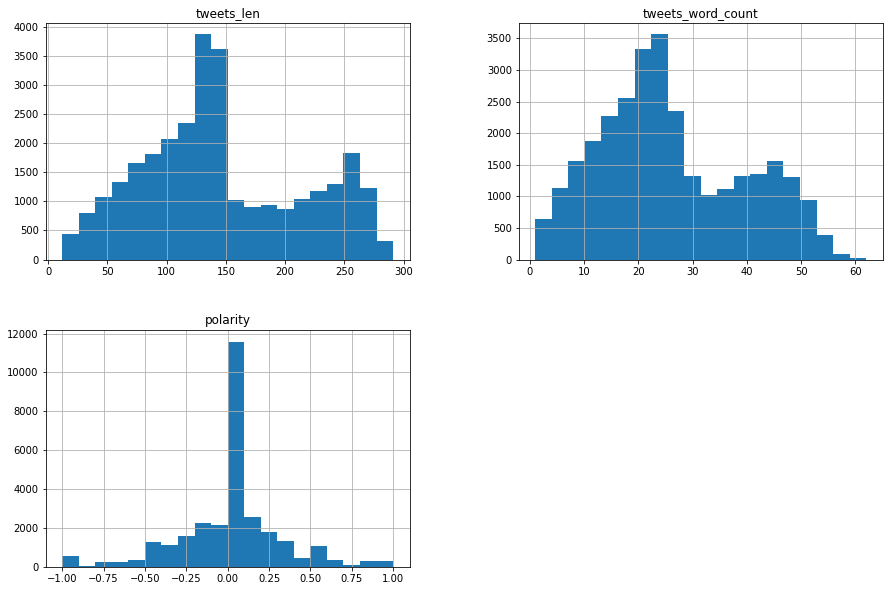

In [8]:
# Vẽ biểu đồ phân phối các đặc trưng
df[["tweets_len", "tweets_word_count", "polarity"]].hist(bins=20, figsize=(15, 10))

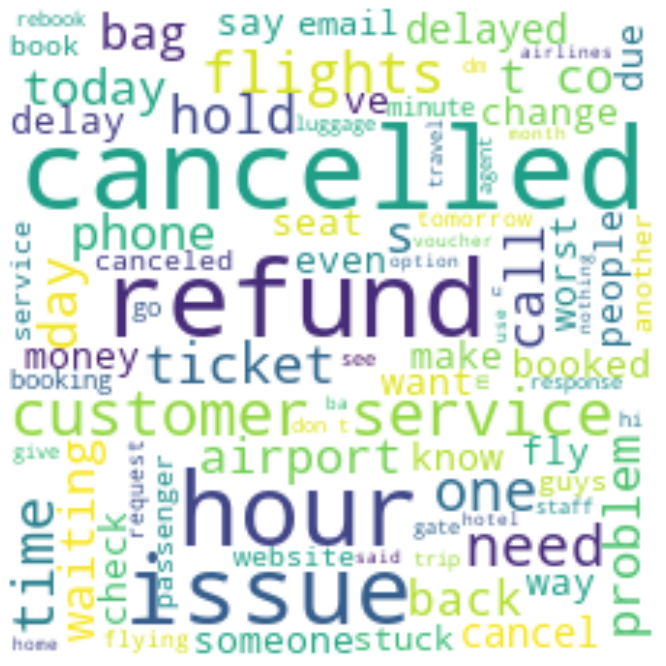

In [9]:
# Tạo word cloud từ các tweet
mask = np.array(Image.open('./tele_mask.png'))  # Đọc ảnh để làm mặt nạ cho word cloud
text = " ".join(review for review in df.text)  # Gộp tất cả text thành chuỗi duy nhất
stopwords = set(STOPWORDS)  # Lấy danh sách stopwords
eda_stop_words = pd.read_csv('../data/eda.csv')  # Đọc danh sách stopwords mở rộng từ file
stopwords.update(eda_stop_words['words'].tolist())  # Bổ sung stopwords

# Tạo mây từ với stopwords và mặt nạ
wordcl = WordCloud(stopwords=stopwords, mask=mask, background_color='white',
                   max_font_size=50, max_words=5000).generate(text)
plt.figure(figsize=(14, 12))  # Kích thước biểu đồ
plt.imshow(wordcl, interpolation='bilinear')  # Hiển thị mây từ
plt.axis('off')  # Tắt trục
plt.show()  # Hiển thị biểu đồ